<a href="https://colab.research.google.com/github/hezzie95/Data-analysis/blob/master/%EC%9C%A0%ED%8A%9C%EB%B8%8C%EB%A1%9C_%EB%B3%B4%EB%8A%94_%EC%B5%9C%EA%B7%BC%EC%9D%98_%ED%8A%B8%EB%A0%8C%EB%93%9C_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##한글 인코딩을 위한 작업

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


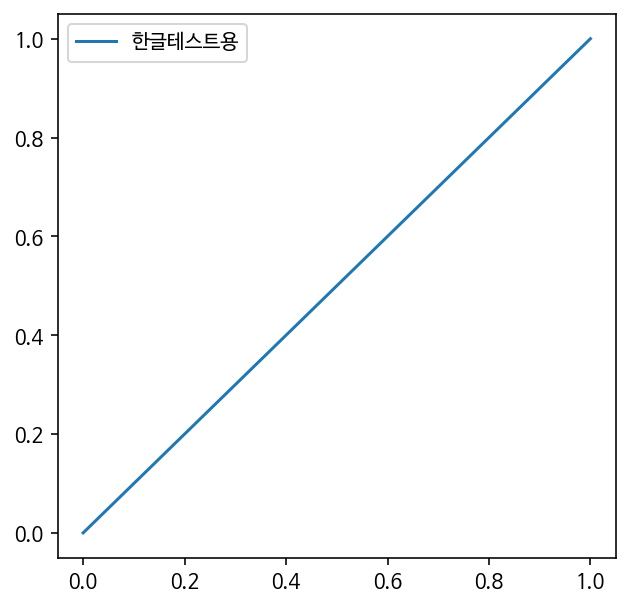

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

##데이터 설명

###데이터 출처: https://www.kaggle.com/rsrishav/youtube-trending-video-dataset?select=KR_youtube_trending_data.csv

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
Youtube=pd.read_csv("/content/drive/MyDrive/KR_youtube_trending_data.csv")

In [ ]:
Youtube.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09T09:32:48Z,UCu9BCtGIEr73LXZsKmoujKw,보겸 BK,24,2020-08-12T00:00:00Z,보겸|bokyem,5947503,53326,105756,139946,https://i.ytimg.com/vi/uq5LClQN3cE/default.jpg,False,False,NaN
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12T09:00:08Z,UCRuSxVu4iqTK5kCh90ntAgA,총몇명,1,2020-08-12T00:00:00Z,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,https://i.ytimg.com/vi/I-ZbZCHsHD0/default.jpg,False,False,"오늘도 정말 감사드립니다!!총몇명 스튜디오 - 총몇명, 십제곱, 5G민, MOVE혁..."
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10T09:54:13Z,UCMVC92EOs9yDJG5JS-CMesQ,양팡 YangPang,22,2020-08-12T00:00:00Z,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,https://i.ytimg.com/vi/9d7jNUjBoss/default.jpg,False,False,NaN
3,3pI_L3-sMVg,안녕하세요 꽈뚜룹입니다.,2020-08-11T15:00:58Z,UCkQCwnkQfgSuPTTnw_Y7v7w,꽈뚜룹 Quaddurup,24,2020-08-12T00:00:00Z,꽈뚜룹|한국여행기|quaddurup|뚜룹이|korea|southkorea|vlog|...,1743374,36893,1798,8751,https://i.ytimg.com/vi/3pI_L3-sMVg/default.jpg,False,False,앞으로 좀 더 깔끔한 영상제작 약속 드리겠습니다.늘 감사드립니다
4,zrsBjYukE8s,박진영 (J.Y. Park) When We Disco (Duet with 선미) M/V,2020-08-11T09:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|J.Y.Park|JYPark|박진영|선미|S...,3433885,353337,9763,23405,https://i.ytimg.com/vi/zrsBjYukE8s/default.jpg,False,False,MelOn http://kko.to/TWyXd7zYjSpotify https://s...


#1.문제 정의

* 최근 유튜브 트렌드는 무엇일까?

#2. 분석 과정

문제에 대한 해답을 도출하기 위해 워드 클라우드로 빈도수가 높은 단어들을 출력하였습니다.</br>



**프로세스**

1단계: 데이터 전처리를 진행한다.</br>
2단계: 형태소 분석기를 이용하여 단어를 추출한다</br>
3단계: 추출한 단어의 빈도수를 측정하여, 최근의 트렌드와 관련된 단어를 워드크라우드로 나타낸다.</br>

cf. 추가로 LDA 토픽 모델링을 이용하여, 서로 관련있는 단어를 묶어보고 트렌드의 큰 줄기를 추측해본다..

###(1) 데이터 전처리

우선 어느 기간의 데이터인지 확인해보겠습니다. 

In [ ]:
import datetime

Youtube['publishedAt']=pd.to_datetime(Youtube['publishedAt'])
Youtube['trending_date']=pd.to_datetime(Youtube['trending_date'])

In [ ]:
Youtube[['publishedAt','trending_date']].describe()

,publishedAt,trending_date
count,66554,66554
unique,9314,328
top,2021-06-02 09:00:10+00:00,2021-05-31 00:00:00+00:00
freq,36,400
first,2020-08-05 02:00:03+00:00,2020-08-12 00:00:00+00:00
last,2021-07-18 19:41:12+00:00,2021-07-19 00:00:00+00:00


2020년도의 데이터도 섞여있네요.</br>
trending_date가 2021년인 데이터만 사용하겠습니다.

In [ ]:
df=Youtube[Youtube['trending_date'].dt.year==2021]

In [ ]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
24555,yKGrcJw6WLs,[신병] 물자창고,2020-12-31 08:00:04+00:00,UChbE5OZQ6dRHECsX0tEPEZQ,장삐쭈,23,2021-01-01 00:00:00+00:00,장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...,1893473,38249,730,8595,https://i.ytimg.com/vi/yKGrcJw6WLs/default.jpg,False,False,"스튜디오 장삐쭈장삐쭈, 정영준, 안류천, 포포, 윤성원, 허혜원, 정대준suppor..."
24556,-Bf_BB9iTNI,RAIN(비) - 나로 바꾸자 Switch to me (duet with JYP) MV,2020-12-31 09:00:01+00:00,UCxXgIeE5hxWxHG6dz9Scg2w,RAIN's Official Channel,10,2021-01-01 00:00:00+00:00,레인|RAIN|레인컴퍼니|가수비|정지훈,2600864,0,0,20129,https://i.ytimg.com/vi/-Bf_BB9iTNI/default.jpg,False,True,RAIN X JYP나로 바꾸자 (duet with JYP) MV2020.12.31 ...
24557,aPmrxH3Sh4Y,2020년 제야의 종 온라인 타종행사 | 보신각 현장 행사는 진행하지 않습니다.,2020-12-31 15:22:25+00:00,UCZUPZW5idAxYp-Asj__lVAA,서울시 · Seoul,29,2021-01-01 00:00:00+00:00,2020년|제야의종|타종|2021년|새해|신축년,347049,3564,120,178,https://i.ytimg.com/vi/aPmrxH3Sh4Y/default.jpg,False,False,일시 : 2020년 12월 31일 (목) 밤 11시 30분내용 : 2020년 제야의...
24558,YE1tLDzvs-M,고기남자의 칠면조 파티,2020-12-31 12:45:11+00:00,UCT3CumbFIJiW33uq0UI3zlg,고기남자 MeatMan,26,2021-01-01 00:00:00+00:00,칠면조|크리스마스|터키|칠면조 요리|칠면조 먹방|칠면조 다리|고기남자,528458,15372,280,3470,https://i.ytimg.com/vi/YE1tLDzvs-M/default.jpg,False,False,첫 손님 ...
24559,cMtZd-h8b6o,골목 3mc를 분노하게 만든 마음고생이 심했을 공릉 백반집 사장님의 푸념?! [예능...,2020-12-31 10:02:14+00:00,UCdWgRSfttvDucq4ApcCg5Mw,스브스밥집,24,2021-01-01 00:00:00+00:00,공릉 백종원|백종원의 골목식당|골목식당|찌개백반집|골목식당 백반집|예능|백종원 백반...,494904,3918,111,3142,https://i.ytimg.com/vi/cMtZd-h8b6o/default.jpg,False,False,골목 3mc를 분노하게 만든 마음고생이 심했을 공릉 백반집 사장님의 푸념?! [예능...


필요한 칼럼만 추출하고, view 수가 많은 순으로 정렬하겠습니다.

In [ ]:
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description'],
      dtype='object')

In [ ]:
df = df[['title','view_count']]
df_sorted = df.sort_values(by="view_count", ascending=False).drop_duplicates(['title'], keep="first")
df_sorted

,title,view_count
55138,BTS (방탄소년단) 'Butter' Official MV,296314174
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664
41350,ROSÉ - 'On The Ground' M/V,117461115
61342,TWICE Alcohol-Free M/V,104119672
53553,aespa 에스파 'Next Level' MV,84077957
...,...,...
28930,그래서 너프야?아니야? 저렴해진 플래그십 갤럭시S21/S21U 좋아지고 나빠진점.,33121
27146,전북 전 지역 대설·한파특보 발효… | 2021.01.07 목 KBS뉴스특보,31424
28934,해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20...,27991
24599,Hello 2021 Korea | 크리에이터와 함께하는 Goodbye 2020,0


In [ ]:
df_hot = df_sorted
df_hot

,title,view_count
55138,BTS (방탄소년단) 'Butter' Official MV,296314174
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664
41350,ROSÉ - 'On The Ground' M/V,117461115
61342,TWICE Alcohol-Free M/V,104119672
53553,aespa 에스파 'Next Level' MV,84077957
...,...,...
28930,그래서 너프야?아니야? 저렴해진 플래그십 갤럭시S21/S21U 좋아지고 나빠진점.,33121
27146,전북 전 지역 대설·한파특보 발효… | 2021.01.07 목 KBS뉴스특보,31424
28934,해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20...,27991
24599,Hello 2021 Korea | 크리에이터와 함께하는 Goodbye 2020,0


In [ ]:
df_hot['title'].values

array(["BTS (방탄소년단) 'Butter' Official MV",
       "BTS (방탄소년단) 'Permission to Dance' Official MV",
       "ROSÉ - 'On The Ground' M/V", ...,
       '해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20층높이 실화야?!',
       'Hello 2021 Korea | 크리에이터와 함께하는 Goodbye 2020',
       'Earth Day 2021 Doodle'], dtype=object)

정규표현식을 통해 한글만 출력되도록 지정하겠습니다.

In [ ]:
import re
df_hot['title_refined'] = df_hot['title'].apply(lambda x: re.sub('[^가-힣\s]', '', x))
df_hot

,title,view_count,title_refined
55138,BTS (방탄소년단) 'Butter' Official MV,296314174,방탄소년단
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664,방탄소년단
41350,ROSÉ - 'On The Ground' M/V,117461115,
61342,TWICE Alcohol-Free M/V,104119672,
53553,aespa 에스파 'Next Level' MV,84077957,에스파
...,...,...,...
28930,그래서 너프야?아니야? 저렴해진 플래그십 갤럭시S21/S21U 좋아지고 나빠진점.,33121,그래서 너프야아니야 저렴해진 플래그십 갤럭시 좋아지고 나빠진점
27146,전북 전 지역 대설·한파특보 발효… | 2021.01.07 목 KBS뉴스특보,31424,전북 전 지역 대설한파특보 발효 목 뉴스특보
28934,해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20...,27991,해부심을걸고 싸우는 기수빨없는 해병대 해병대의 아이스 클라이밍 대결 층높이 실화야
24599,Hello 2021 Korea | 크리에이터와 함께하는 Goodbye 2020,0,크리에이터와 함께하는


title_refined에 빈값이 있는 것 같으니, 값이 있는 데이터들만 정리하겠습니다.

In [ ]:
df_hot = df_hot[df_hot['title_refined'].apply(lambda x: re.sub('[^가-힣]', '', x)) != '']
df_hot

,title,view_count,title_refined
55138,BTS (방탄소년단) 'Butter' Official MV,296314174,방탄소년단
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664,방탄소년단
53553,aespa 에스파 'Next Level' MV,84077957,에스파
52947,NCT DREAM 엔시티 드림 '맛 (Hot Sauce)' MV,81767273,엔시티 드림 맛
45147,BTS (방탄소년단) 'Film out' Official MV,78893765,방탄소년단
...,...,...,...
27954,"셀트리온, 첫 국산 치료제 유력…허가시 2월 처방?",36644,셀트리온 첫 국산 치료제 유력허가시 월 처방
28930,그래서 너프야?아니야? 저렴해진 플래그십 갤럭시S21/S21U 좋아지고 나빠진점.,33121,그래서 너프야아니야 저렴해진 플래그십 갤럭시 좋아지고 나빠진점
27146,전북 전 지역 대설·한파특보 발효… | 2021.01.07 목 KBS뉴스특보,31424,전북 전 지역 대설한파특보 발효 목 뉴스특보
28934,해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20...,27991,해부심을걸고 싸우는 기수빨없는 해병대 해병대의 아이스 클라이밍 대결 층높이 실화야


##(2) 형태소 분석기(sonynlp)로 단어 추출하기

형태소 분석기


In [ ]:
pip install soynlp

     |████████████████████████████████| 416 kB 5.0 MB/s 


In [ ]:
from soynlp.word import WordExtractor

word_extractor = WordExtractor(min_frequency=10,
    min_cohesion_forward=0.05,
    min_right_branching_entropy=0.0
)
word_extractor.train(df_hot['title_refined'].values) # list of str or like
words = word_extractor.extract()
words

training was done. used memory 0.289 Gb
all cohesion probabilities was computed. # words = 1717
all branching entropies was computed # words = 10379
all accessor variety was computed # words = 10379


{'몸': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=1.3862943611198906, right_branching_entropy=-0.0, left_accessor_variety=4, right_accessor_variety=1, leftside_frequency=19, rightside_frequency=0),
 '창': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=-0.0, right_branching_entropy=-0.0, left_accessor_variety=1, right_accessor_variety=1, leftside_frequency=0, rightside_frequency=16),
 '막': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=1.1355555272862874, right_branching_entropy=1.8014974326764825, left_accessor_variety=7, right_accessor_variety=7, leftside_frequency=32, rightside_frequency=38),
 '완': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=2.012692643809282, right_branching_entropy=0.6782093939033127, left_accessor_variety=8, right_accessor_variety=2, leftside_frequency=49, rightside_frequency=0),
 '운': Scores(cohesion_forward=0, cohesion_backward=0, left_branching_entropy=2.3540505

LTokenizer 설명

In [ ]:
from soynlp.tokenizer import LTokenizer
cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)

In [ ]:
df_hot['tokenized'] = df_hot['title_refined'].apply(lambda x: tokenizer.tokenize(x, remove_r=True))
df_hot

,title,view_count,title_refined,tokenized
55138,BTS (방탄소년단) 'Butter' Official MV,296314174,방탄소년단,[방탄소년단]
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664,방탄소년단,[방탄소년단]
53553,aespa 에스파 'Next Level' MV,84077957,에스파,[에스파]
52947,NCT DREAM 엔시티 드림 '맛 (Hot Sauce)' MV,81767273,엔시티 드림 맛,"[엔시티, 드림, 맛]"
45147,BTS (방탄소년단) 'Film out' Official MV,78893765,방탄소년단,[방탄소년단]
...,...,...,...,...
27954,"셀트리온, 첫 국산 치료제 유력…허가시 2월 처방?",36644,셀트리온 첫 국산 치료제 유력허가시 월 처방,"[셀트리온, 첫, 국산, 치료제, 유력허가시, 월, 처방]"
28930,그래서 너프야?아니야? 저렴해진 플래그십 갤럭시S21/S21U 좋아지고 나빠진점.,33121,그래서 너프야아니야 저렴해진 플래그십 갤럭시 좋아지고 나빠진점,"[그래서, 너프야아니야, 저렴해진, 플래그십, 갤럭시, 좋아, 나빠진점]"
27146,전북 전 지역 대설·한파특보 발효… | 2021.01.07 목 KBS뉴스특보,31424,전북 전 지역 대설한파특보 발효 목 뉴스특보,"[전북, 전, 지역, 대설한파특보, 발효, 목, 뉴스]"
28934,해부심을걸고 싸우는 기수빨없는 해병대 vs 해병대의 아이스 클라이밍 대결ㅋㅋㅋ 20...,27991,해부심을걸고 싸우는 기수빨없는 해병대 해병대의 아이스 클라이밍 대결 층높이 실화야,"[해부심을걸고, 싸우는, 기수빨없는, 해병대, 해병대의, 아이, 클라, 대결, 층높..."


50만뷰가 넘는 영상만 출력해보겠습니다.

In [ ]:
df_hot_top = df_hot[df_sorted['view_count'] > 500000]
df_hot_top

,title,view_count,title_refined,tokenized
55138,BTS (방탄소년단) 'Butter' Official MV,296314174,방탄소년단,[방탄소년단]
66466,BTS (방탄소년단) 'Permission to Dance' Official MV,172293664,방탄소년단,[방탄소년단]
53553,aespa 에스파 'Next Level' MV,84077957,에스파,[에스파]
52947,NCT DREAM 엔시티 드림 '맛 (Hot Sauce)' MV,81767273,엔시티 드림 맛,"[엔시티, 드림, 맛]"
45147,BTS (방탄소년단) 'Film out' Official MV,78893765,방탄소년단,[방탄소년단]
...,...,...,...,...
35947,오빠는 나 얼마나 좋아해?,500674,오빠는 나 얼마나 좋아해,"[오빠, 나, 얼마나, 좋아]"
64088,[SMTM10] WINNER CYPHER - lIlBOI (래퍼 공개모집 ~7/31),500148,래퍼 공개모집,"[래퍼, 공개]"
51952,[몰카]여자후배가 우리집에 배달을 온다면? 8탄 Ft. 이승윤,500125,몰카여자후배가 우리집에 배달을 온다면 탄 이승윤,"[몰카, 우리, 배달을, 온다면, 탄, 이승윤]"
25553,혜리 Vlog | 갑자기 생긴 휴일🎶 혜리는 쉬는 날 뭘 할까? 아듀 2020!,500098,혜리 갑자기 생긴 휴일 혜리는 쉬는 날 뭘 할까 아듀,"[혜리, 갑자기, 생긴, 휴일, 혜리는, 쉬는, 날, 뭘, 할까, 아듀]"


Bag of Words, 즉 단어들만 들어있는 리스트를 만들어 보겠습니다.

In [ ]:
words = []
for i in df_hot_top['tokenized'].values:
  for k in i:
    words.append(k)
words

['방탄소년단',
 '방탄소년단',
 '에스파',
 '엔시티',
 '드림',
 '맛',
 '방탄소년단',
 '마피아',
 '엑소',
 '방탄소년단',
 '에버글로우',
 '엔시티',
 '드림',
 '방탄소년단',
 '여자아이들',
 '화',
 '방탄소년단',
 '방탄소년단',
 '방탄소년단',
 '강다니엘',
 '방탄소년단',
 '이달의',
 '소녀',
 '아이',
 '니쥬',
 '브레이브걸스',
 '치맛바람',
 '몬스타엑스',
 '샤이니',
 '방탄소년단',
 '강다니엘',
 '백현',
 '해야',
 '해',
 '방탄소년단',
 '선미',
 '꼬리',
 '청하',
 '오마이걸',
 '아이',
 '스테이',
 '방탄소년단',
 '펜타곤',
 '아스트로',
 '제시',
 '어떤',
 '방탄소년단',
 '방탄소년단',
 '에스파',
 '약속',
 '슈퍼',
 '방탄소년단',
 '현아',
 '드림',
 '태민',
 '에이',
 '감아',
 '샤이니',
 '투모로우바이투게더',
 '하이라이트',
 '불어',
 '온앤오프',
 '방탄소년단',
 '왜왜왜',
 '프로',
 '방탄소년단',
 '무엇이든',
 '물어보',
 '지효',
 '마녀식당으로',
 '오세요',
 '방탄소년단',
 '보기만해도',
 '힐링되는',
 '가지',
 '생크림케익',
 '만들기',
 '카네이션딸기초코레인보우',
 '하이라이트',
 '만남',
 '성사',
 '진짜',
 '와',
 '여고생의',
 '만남',
 '살아',
 '전소연',
 '삠삠',
 '라잇썸',
 '로켓펀치',
 '아이',
 '킬링',
 '라이브',
 '하루',
 '끝',
 '너의',
 '의미',
 '스물셋',
 '밤편지',
 '팔레트',
 '가을',
 '아침',
 '삐삐',
 '에잇',
 '라일락',
 '방탄소년단',
 '우주소녀',
 '마마무',
 '김우석',
 '트와이스',
 '제가',
 '유튜브',
 '시작',
 '에스파',
 '태연',
 '놀면',
 '뭐하니',
 '후공개',
 '워너비',
 '내',
 '사람',
 '풀영

글자수가 한 개인 경우는 보통 의미없는 단어인 경우가 많으므로 BoW에서 없애도록 하겠습니다.

In [ ]:
for i in words:
  if len(i)==1:
    words.remove(i)


Bow에 있는 단어들의 빈도수를 센 후, 그것을 기준으로 워드클라우드를 그려보겠습니다.

In [ ]:
from collections import Counter
count = Counter(words)
words_dict = dict(count)
print(words_dict)

{'방탄소년단': 55, '에스파': 26, '엔시티': 5, '드림': 12, '마피아': 21, '엑소': 2, '에버글로우': 1, '여자아이들': 16, '강다니엘': 5, '이달의': 1, '소녀': 2, '아이': 95, '니쥬': 1, '브레이브걸스': 78, '치맛바람': 10, '몬스타엑스': 1, '샤이니': 16, '백현': 5, '해야': 5, '선미': 7, '꼬리': 28, '청하': 7, '오마이걸': 7, '스테이': 1, '펜타곤': 1, '아스트로': 1, '제시': 6, '어떤': 13, '약속': 2, '슈퍼': 38, '현아': 17, '태민': 4, '에이': 5, '감아': 1, '투모로우바이투게더': 3, '하이라이트': 46, '불어': 5, '온앤오프': 4, '왜왜왜': 2, '프로': 28, '무엇이든': 11, '물어보': 4, '지효': 2, '마녀식당으로': 2, '오세요': 2, '보기만해도': 1, '힐링되는': 1, '가지': 39, '생크림케익': 1, '만들기': 34, '카네이션딸기초코레인보우': 1, '만남': 9, '성사': 2, '진짜': 45, '여고생의': 1, '살아': 15, '전소연': 2, '삠삠': 3, '라잇썸': 1, '로켓펀치': 1, '킬링': 18, '라이브': 29, '하루': 21, '너의': 3, '의미': 1, '스물셋': 1, '밤편지': 1, '팔레트': 10, '가을': 1, '아침': 4, '삐삐': 1, '에잇': 1, '라일락': 8, '우주소녀': 1, '마마무': 1, '김우석': 1, '트와이스': 8, '제가': 7, '유튜브': 15, '시작': 40, '태연': 12, '놀면': 24, '뭐하니': 22, '후공개': 12, '워너비': 22, '사람': 55, '풀영상': 17, '웬디': 2, '조이': 4, '안녕': 7, '다시': 31, '호비의': 2, '생일': 17, '축하해주세요': 2, '모르는': 9, '척하기': 1, 

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='white', width=500, height=500).generate_from_frequencies(words_dict)


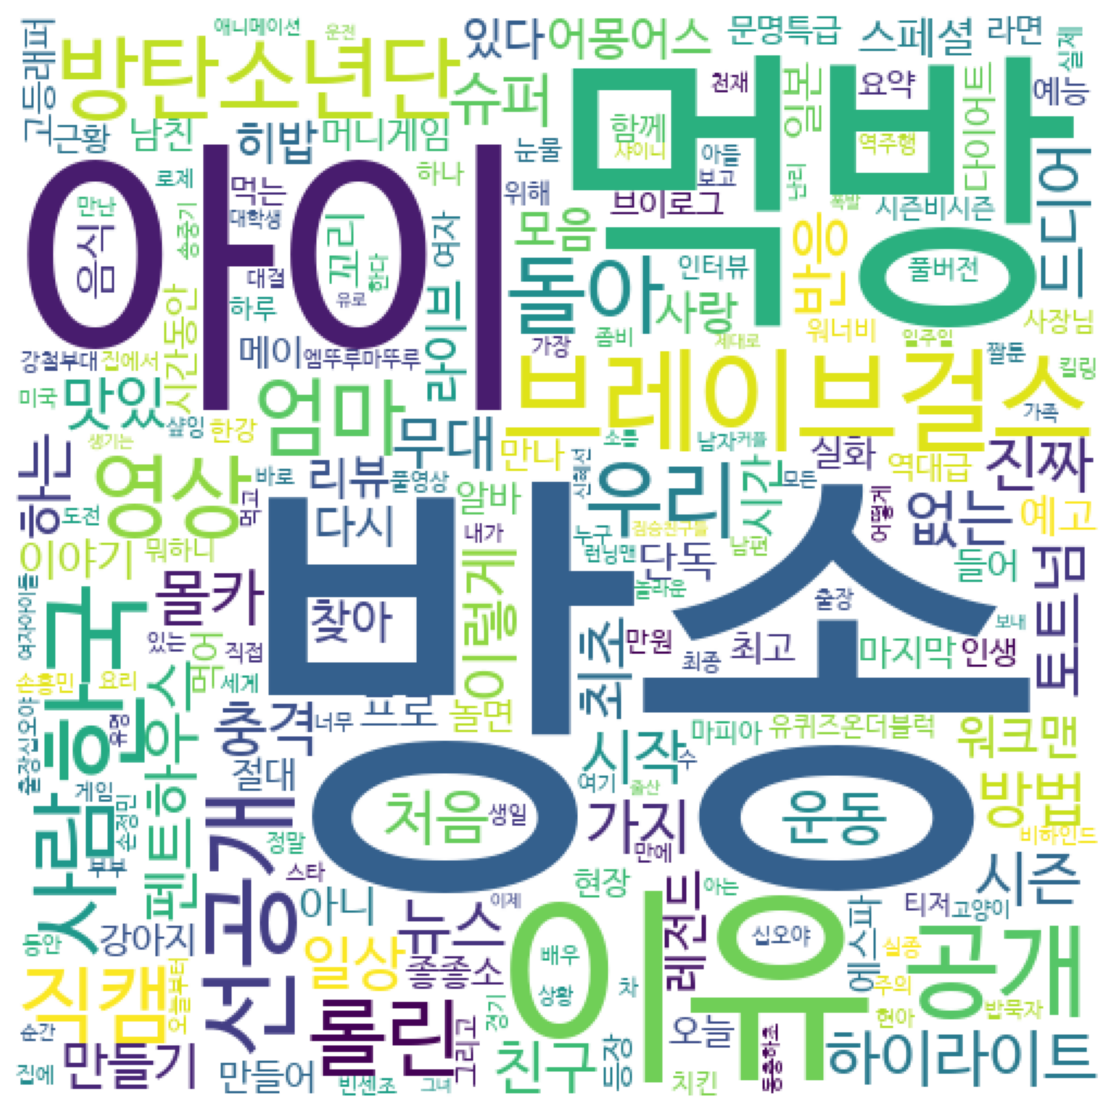

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

의미를 파악하기 힘든 단어들을 지워줍니다.

In [ ]:
stopwords = {'진짜','영상','선공개','아이','이유','방송','있다','드디어','절대','처음','우리','단독','예고','모든','시즌','공개','오늘'}
for word in stopwords:
  words_dict.pop(word)

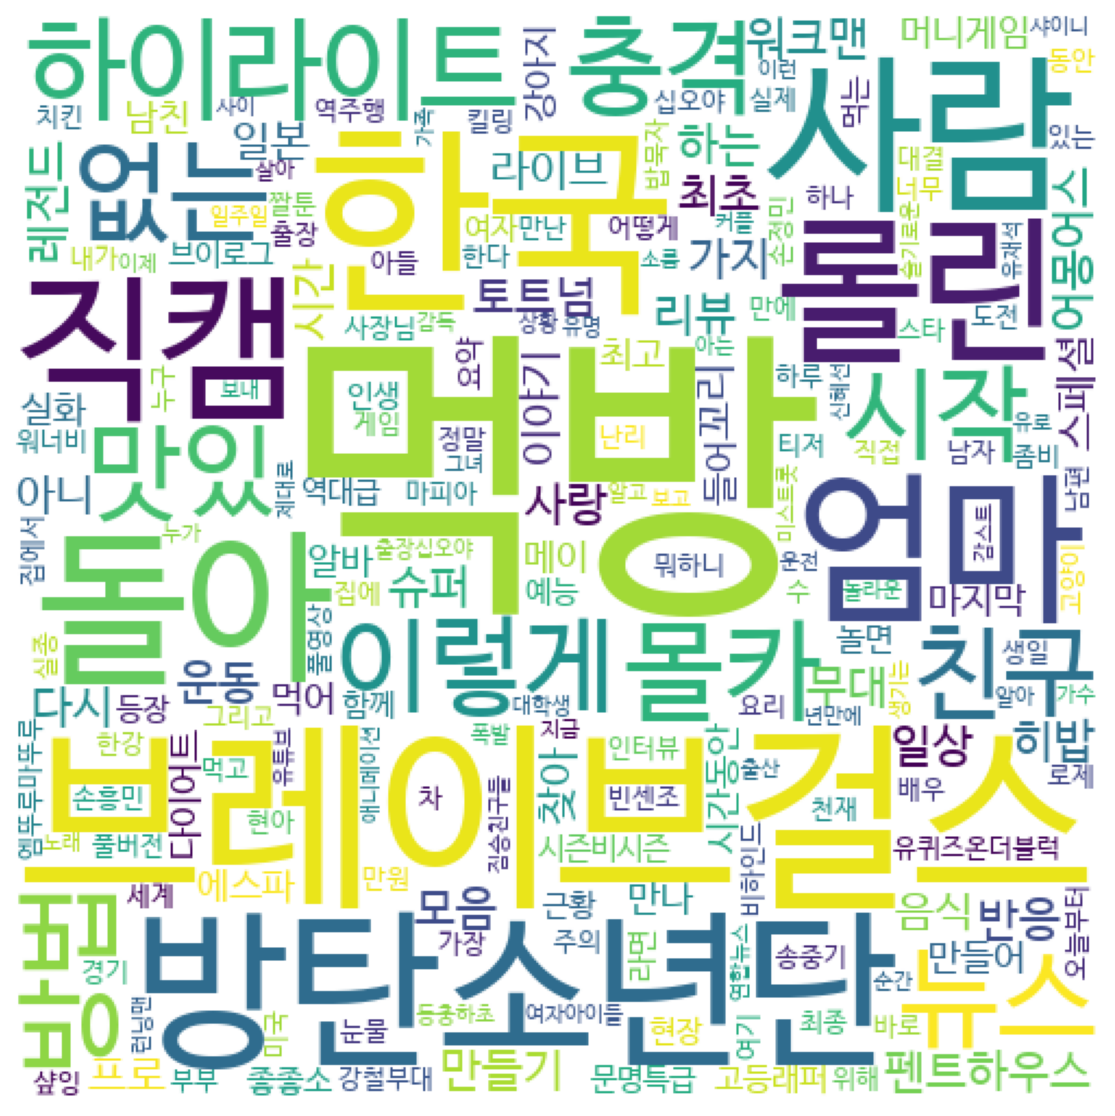

In [ ]:
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='white', width=500, height=500).generate_from_frequencies(words_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**먹방, 브레이브 걸스, 방탄소년단, 하이라이트, 한국, 직캠**과 관련된 것들이 최근의 트렌드인 것 같네요.

##Plus) 추가로 간단하게 토픽 분류를 해보도록 하겠습니다.

In [ ]:
line_list=df_hot_top['tokenized'].to_list()

In [ ]:
import gensim
from gensim import corpora
import logging
logging.basicConfig(level=logging.DEBUG)
topic = 5
keyword = 3
texts = []
resultList = []
stop_list = ['진짜','영상','선공개','아이','이유','방송','있다','드디어','절대','처음','우리','단독','예고','모든','시즌','공개','오늘']
for line in line_list:
    words = line
    if words != [""]:
        tokens = [word for word in words if (len(word.split("/")[0]) > 1 and word.split("/")[0] not in stop_list)]
        texts.append(tokens)
dictionary = corpora.Dictionary(texts)    
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=topic, id2word = dictionary, passes=10)
for num in range(topic):
    resultList.append(ldamodel.show_topic(num, keyword))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(9572 unique tokens: ['방탄소년단', '에스파', '드림', '엔시티', '마피아']...) from 3381 documents (total 21598 corpus positions)
INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 3381 documents, updating model once every 2000 documents, evaluating perplexity every 3381 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3381
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1808/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:m

In [ ]:
resultList

[[('한국', 0.007970904), ('반응', 0.0055766986), ('충격', 0.004754898)],
 [('브레이브걸스', 0.00924653), ('롤린', 0.0072019165), ('직캠', 0.0069591324)],
 [('먹방', 0.007510852), ('만들기', 0.0044952757), ('남친', 0.0038552834)],
 [('방탄소년단', 0.006496989), ('방법', 0.0060480745), ('일주일', 0.0035633862)],
 [('돌아', 0.0059787417), ('어몽어스', 0.005594546), ('일상', 0.004857787)]]

#3. 결론

**키워드**: 먹방, 브레이브 걸스, 방탄소년단, 한국, 직캠</br>

키워드와 LDA 토픽 모델링으로 추측해본 **유튜브 인기동영상 제목**은 
1. **애국심 동영상**    ex) 한국의 ~~를 보고 충격받은 외국인 반응!
2. **브레이브 걸스 롤린 직캠**
3. **먹방**:  ex)남친과 만든 음식 먹방
4. **방탄소년단**  ex)방탄소년단이 일주일동안 생활하는 방법

등으로 예측해볼 수 있겠습니다.
